In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np

In [2]:
#TACO annotations & images locations
taco_path = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\TACO\TACO-master\data"

In [3]:
import random

#reads verge image
def getVerge(p):
    return cv2.cvtColor(cv2.imread(p),cv2.COLOR_BGR2RGB)

#########
#change this to object
############
#get image and mask according to image ID
#takes path of TACO data and list of image IDs
def getTaco(p, imIds):   
    ann_path = os.path.join(p, "annotations.json")
    coco = COCO(ann_path)
    
    litIms = []
    litMasks = []
    for imId in imIds: #for each image selected
        #get image object from coco annotations
        img = coco.imgs[imId]
        
        #get file name and join it to data path
        imp = os.path.join(p, img['file_name'])
        
        #get category ids
        cat_ids = coco.getCatIds()
        #get annotation ids
        anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(anns_ids)
        
        #load taco image
        im = cv2.cvtColor(cv2.imread(imp),cv2.COLOR_BGR2RGB)
        
        #for each annotation....
        
        for i, ann in enumerate (anns):
            mask = coco.annToMask(anns[i])

            #crop image and mask
            img_h,img_w,c = im.shape


            [x,y,w,h] = anns[i]['bbox']
            cropped_img = im[int(y):int(y+h), int(x):int(x+w),  :]
            cropped_mask = mask[int(y):int(y+h), int(x):int(x+w)]

            #Cutout rubbish using mask
            cut_img = cv2.bitwise_and(cropped_img,cropped_img,mask = cropped_mask)
        
        #add to array of samples
        litIms.append(cut_img)
        litMasks.append(cropped_mask)
        
    return litIms, litMasks

    
#https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)
    
    new_w = dim[0]
    new_h = dim[1]
    
    # return the resized image
    return resized, new_w, new_h

#combine litter and subsection of an image -> x1 and y1 are top-left of litter bounding box (top left cropped sample)
def combine(litter_im, litter_mask, verge, x1, y1, rotate = False):
    #Add images together
    
    #if rotate ==True, randomly rotate (possibility of no rotation '0' degrees)
    if rotate:
        angle = random.choice([-90,0,90,180])
        if angle == -90:
            litter_im = cv2.rotate(litter_im,cv2.ROTATE_90_COUNTERCLOCKWISE)
            litter_mask = cv2.rotate(litter_mask,cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif angle == 90:
            litter_im = cv2.rotate(litter_im,cv2.ROTATE_90_CLOCKWISE)
            litter_mask = cv2.rotate(litter_mask,cv2.ROTATE_90_CLOCKWISE)
        elif angle ==180:
            litter_im = cv2.rotate(litter_im,cv2.ROTATE_180)
            litter_mask = cv2.rotate(litter_mask,cv2.ROTATE_180)
            
    #https://www.binarystudy.com/2022/09/How-to-add-subtract-different-size-images-using-OpenCV-Python.html#:~:text=Alternatively%20you%20can%20use%20cv2.addWeighted%20%28%29%20to%20add,cv2.addWeighted%20%28img11%2C%200.3%2C%20img22%2C%200.7%2C%200%29%20plt.imshow%20%28img_add%29

    # Find the minimum height and width of the two images
    min_height = litter_im.shape[0]
    min_width = litter_im.shape[1]

    # Crop images with minimum height and width (object height/width)
    foreground = litter_im
    background = verge[y1-min_height:y1,x1:x1+min_width]
    
    (Rb, Gb, Bb) = cv2.split(background)
    (Rf, Gf, Bf) = cv2.split(foreground)


    #invert mask
    inv_mask = 1-litter_mask


    #In each colour channel, cut out mask and add foreground channels
    
    Rn = cv2.bitwise_and(Rb,Rb,mask=inv_mask) + Rf
    Gn = cv2.bitwise_and(Gb,Gb,mask=inv_mask) + Gf
    Bn = cv2.bitwise_and(Bb,Bb,mask=inv_mask) + Bf

    #merge channels back together
    merged = cv2.merge([Rn,Gn,Bn])
    
    verge[y1-min_height:y1,x1:x1+min_width] = merged
    
    return verge, min_width, min_height #min width and min height are returned incase of rotation (Swaps points)


loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


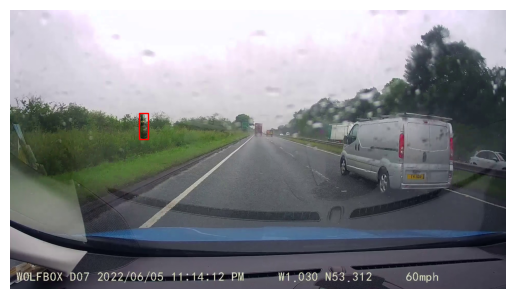

In [4]:
import matplotlib.patches as patches

v_path = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\segmentation\seg_dataset\gv_seg\20220605231413_000097_Trim_frame2.jpg"
#get cropped taco image and mask
ims, masks = getTaco(taco_path,[0])

verge = getVerge(v_path)


new_lit_height = 100
#resize litter to height 100
context_cut, w , h = image_resize(ims[0],height=new_lit_height) ; context_mask,_,_ = image_resize(masks[0],height=new_lit_height)

locx = 500
locy = 500

#combine with background
merged,nw,nh = combine(context_cut, context_mask, verge, locx , locy)

rect = patches.Rectangle((locx, locy-nh), nw, nh, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()

ax.add_patch(rect)

plt.axis('off')
plt.imshow(merged)


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


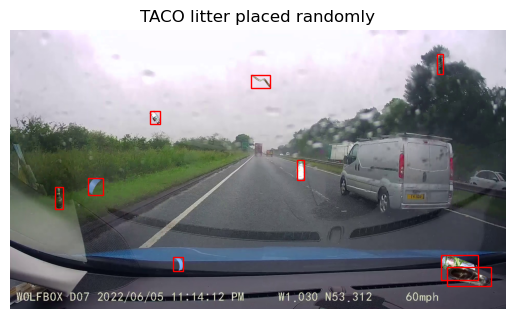

In [5]:
#random placement
import random

#get height & width of verge
vh = verge.shape[0]; vw = verge.shape[1]

#placement x must be between (0: vh- litter height)
#placement y must be between (0: vw- litter width)

#get cropped taco image and mask
ims, masks = getTaco(taco_path,[0,1,2,3,4,5,6,7,8])

verge = getVerge(v_path)


merged = verge.copy()

fig, ax = plt.subplots()

for i, litSamp in enumerate(ims):
    
    new_lit_height = random.randint(50,100)# height for litter resizing
    #resize litter to height 100
    context_cut, w , h = image_resize(ims[i],height=new_lit_height) ; context_mask,_,_ = image_resize(masks[i],height=new_lit_height)

    #random locations
    locx = random.randint(w, vw-w) 
    locy = random.randint(h, vh-h)

    #combine with background
    merged, nw, nh = combine(context_cut, context_mask, merged, locx , locy)

    rect = patches.Rectangle((locx, locy-nh), nw, nh, linewidth=1, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)




plt.title("TACO litter placed randomly")
plt.axis('off')
plt.imshow(merged)


In [6]:
#Place in random points from training data samples

#Load points
import pandas as pd
labelCSV = r"C:\Users\Computing\OneDrive - University of Lincoln\MSc Intelligent Vision\Project\copy-paste\Training02.csv"

centx = []
centy = []

#annotations file
df_antt = pd.read_csv(labelCSV)

xmin = df_antt["xmin"].values
ymin = df_antt["ymin"].values
xmax = df_antt["xmax"].values
ymax = df_antt["ymax"].values
width = df_antt["width"].values #width and height of IMAGES
height = df_antt["height"].values

for i, name in enumerate(xmin):
    xcen = float((xmin[i] + xmax[i])) / 2 / width[i] #normalise bboxes for yolo according to image size (YOLO is in format <class> <x centroid> <y centroid> <bb width> <bb height>)
    ycen = float((ymin[i] + ymax[i])) / 2 / height[i]
    
    centx.append(xcen)
    centy.append(ycen)
    
    
###note: currently uses center points for downstream "top left bbox" placement

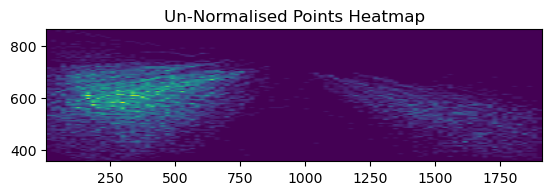

In [7]:
#modify points for verge dimensions
newCentx = np.multiply(centx, vw)
newCenty = np.multiply(centy, vh)

heatmap, xedges, yedges = np.histogram2d(newCentx, newCenty, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, ax = plt.subplots()
plt.clf()
plt.imshow(heatmap.T, extent=extent)
plt.title("Un-Normalised Points Heatmap")

ax.set_xlim(vh)
ax.set_ylim(vw)
plt.show()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


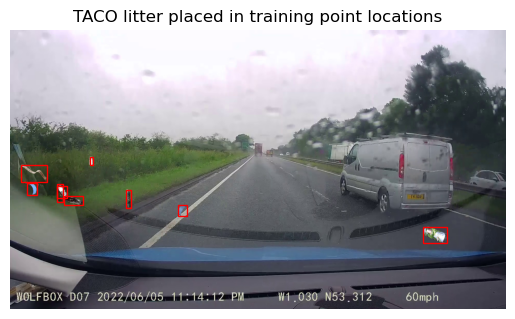

In [8]:
#place along random training points
#get height & width of verge
vh = verge.shape[0]; vw = verge.shape[1]
#placement x must be between (0: vw- litter height)
#placement y must be between (0: vh- litter width)

#get cropped taco image and mask
ims, masks = getTaco(taco_path,[0,1,2,3,4,5,6,7,8])

verge = getVerge(v_path)



merged = verge.copy()

fig, ax = plt.subplots()


pointlen = len(newCentx)
for i, litSamp in enumerate(ims):
    
    new_lit_height = random.randint(30,70)# height for litter resizing

    #resize litter to height 100
    context_cut, w , h = image_resize(ims[i],height=new_lit_height) ; context_mask,_,_ = image_resize(masks[i],height=new_lit_height)
    
    
    rand = random.randint(0,pointlen) #random points from training data
    locx = int(newCentx[rand]-(w/2))#to place in centre, need to provide top-left point (-w, +h)
    locy = int(newCenty[rand]+(h/2))
    
    
    #Check if points within image (object-permitting)
    if locx > vw-w:
        locx = vw-w
        
    if locy > vh-h:
        locy = vh-h

    #combine with background
    merged, nw ,nh = combine(context_cut, context_mask, merged, locx , locy)

    rect = patches.Rectangle((locx, locy-nh), w, h, linewidth=1, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)




plt.axis('off')
plt.title("TACO litter placed in training point locations")
plt.imshow(merged)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


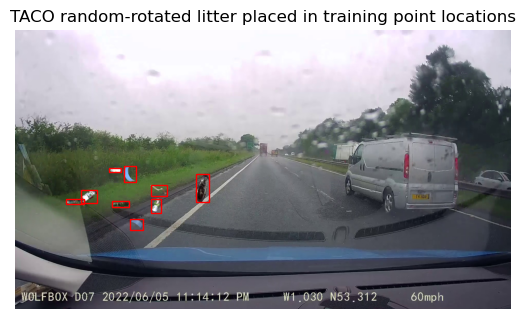

In [9]:
#place along random training points WITH RANDOM ROTATION
#get height & width of verge
vh = verge.shape[0]; vw = verge.shape[1]
#placement x must be between (0: vw- litter height)
#placement y must be between (0: vh- litter width)

#get cropped taco image and mask
ims, masks = getTaco(taco_path,[0,1,2,3,4,5,6,7,8])

verge = getVerge(v_path)



merged = verge.copy()

fig, ax = plt.subplots()


pointlen = len(newCentx)
for i, litSamp in enumerate(ims):
    
    new_lit_height = random.randint(30,70)# height for litter resizing

    #resize litter to height 100
    context_cut, w , h = image_resize(ims[i],height=new_lit_height) ; context_mask,_,_ = image_resize(masks[i],height=new_lit_height)
    
    
    rand = random.randint(0,pointlen) #random points from training data
    locx = int(newCentx[rand]-(w/2))#to place in centre, need to provide top-left point (-w, +h)
    locy = int(newCenty[rand]+(h/2))
    
    
    #Check if points within image (object-permitting)
    if locx > vw-w:
        locx = vw-w
        
    if locx < 0:
        locx = 0
        
    if locy > vh-h:
        locy = vh-h
        
    if locy < 0:
        locy = 0

    #combine with background.
    #save nh nw (could change if rotation)
    merged, nw, nh = combine(context_cut, context_mask, merged, locx , locy, rotate=True)
    
    #patches needs locy-h because it uses bottom-left bbox point as anchor rather than top-left 
    rect = patches.Rectangle((locx, locy-nh), nw, nh, linewidth=1, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)




plt.axis('off')
plt.title("TACO random-rotated litter placed in training point locations")
plt.imshow(merged)

In [10]:
#Place in Segmented verges

In [11]:
#Place in blend of segment/probability